In [23]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus


p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Get triplets functions for cerberus annotation

In [24]:
# def flatten(list_of_lists):
#     if len(list_of_lists) == 0:
#         return list_of_lists
#     if isinstance(list_of_lists[0], list):
#         return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
#     return list_of_lists[:1] + flatten(list_of_lists[1:])

In [25]:
# class CerberusAnnotation():
#     def __init__(self):
#         self.tss = None
#         self.tes = None
#         self.ic = None
        
#         self.tss_map = None
#         self.tes_map = None
#         self.t_map = None
        
#         self.tss_sources = []
#         self.tes_sources = []
#         self.ic_sources = []
#         self.all_sources = []
        
#         self.triplets = None
        
#     def get_sources(self, df):
#         s = [s.split(',') for s in df.source.unique().tolist()]
#         s = list(set(flatten(s)))
#         return s
    
#     def get_all_sources(self):
#         """
#         Get sources that are present in tss, ic, and tes 
#         """
#         all_s = list(set(self.tss_sources)&\
#                      set(self.tes_sources)&\
#                      set(self.ic_sources))
#         return all_s
        
#     def set_tss(self, tss):
#         self.tss = tss
#         self.tss_sources = self.get_sources(self.tss)
#         self.all_sources = self.get_all_sources()
    
#     def set_tes(self, tes):
#         self.tes = tes
#         self.tes_sources = self.get_sources(self.tes)
#         self.all_sources = self.get_all_sources()
        
#     def set_ic(self, ic):
#         self.ic = ic
#         self.ic_sources = self.get_sources(self.ic)
#         self.all_sources = self.get_all_sources()
    
        
# #     def subset_on_source(self, source):
# #         self.tss = self.tss.loc[self.tss.source.str.contains(source)].copy(deep=True)
# #         self.tes = self.tes.loc[self.tes.source.str.contains(source)].copy(deep=True)
# #         self.ic = self.ic.loc[self.ic.source.str.contains(source)].copy(deep=True)
        
# #         return self
#     def set_sg(self, sg):
#         self.sg = sg
        

In [26]:
# def read(h5):
#     c_annot = CerberusAnnotation()
#     ic, tss, tes, tss_map, tes_map, m = read_h5(h5, as_pyranges=False)
#     c_annot.set_tss(tss)
#     c_annot.set_tes(tes)
#     c_annot.set_ic(ic)
#     c_annot.tss_map = tss_map
#     c_annot.tes_map = tes_map
#     c_annot.t_map = m
    
#     return c_annot

In [27]:
# compute triplets from cerberus reference
h5 = 'cerberus_annot.h5'
c_annot = cerberus.read(h5)

In [52]:
c_annot.t_map.head()

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue
0,ENCODEHT000206942,1,ENCODEHG000058846_1,ENCODEHG000058846_1,1,ENCODEHG000058846_1,1,ENCODEHG000058846,ENCODEHG000058846,ENCODEHT000206942,"[1,1,1]","ENCODEHG000058846[1,1,1]","ENCODEHG000058846[1,1,1]",False,False
1,ENCODEHT000206942#0,1,ENCODEHG000058846_1,ENCODEHG000058846_1,1,ENCODEHG000058846_1,1,ENCODEHG000058846,ENCODEHG000058846,ENCODEHT000206942,"[1,1,1]","ENCODEHG000058846[1,1,1]","ENCODEHG000058846[1,1,1]",False,False
2,ENCODEHT000206867,4,ENCODEHG000058837_4,ENCODEHG000058837_2,2,ENCODEHG000058837_1,1,ENCODEHG000058837,ENCODEHG000058837,ENCODEHT000206867,"[2,4,1]","ENCODEHG000058837[2,4,1]","ENCODEHG000058837[2,4,1]",False,False
3,ENCODEHT000206867#0,4,ENCODEHG000058837_4,ENCODEHG000058837_2,2,ENCODEHG000058837_1,1,ENCODEHG000058837,ENCODEHG000058837,ENCODEHT000206867,"[2,4,1]","ENCODEHG000058837[2,4,1]","ENCODEHG000058837[2,4,1]",False,False
4,ENCODEHT000206868,2,ENCODEHG000058837_2,ENCODEHG000058837_2,2,ENCODEHG000058837_1,1,ENCODEHG000058837,ENCODEHG000058837,ENCODEHT000206868,"[2,2,1]","ENCODEHG000058837[2,2,1]","ENCODEHG000058837[2,2,1]",False,False


In [29]:
c_annot.tss.loc[c_annot.tss.gene_id == 'ENSG00000008118']

,Chromosome,Start,End,Strand,Name,source,gene_id,tss
83,chr1,209583663,209583779,+,ENSG00000008118_1,"v40,v29,lapa,lapa,encode_cage,fantom_cage,enco...",ENSG00000008118,1
84,chr1,209607743,209607844,+,ENSG00000008118_2,"v40,v29,fantom_cage,dels",ENSG00000008118,2


In [30]:
c_annot.tss_map.loc[~(c_annot.tss_map.Name.isnull())&(c_annot.tss_map.Name.str.contains('ENSG00000008118'))]

,Chromosome,Start,End,Strand,source,Name
42,chr1,209583663,209583779,+,v40,ENSG00000008118_1
43,chr1,209607743,209607844,+,v40,ENSG00000008118_2
21695,chr1,209583666,209583779,+,v29,ENSG00000008118_1
21696,chr1,209607743,209607844,+,v29,ENSG00000008118_2
25887,chr1,209583676,209583720,+,lapa,ENSG00000008118_1
35265,chr1,209583663,209583779,+,lapa,ENSG00000008118_1
40972,chr1,209583676,209583723,+,encode_cage,ENSG00000008118_1
52446,chr1,209583706,209583724,+,fantom_cage,ENSG00000008118_1
52447,chr1,209607725,209607737,+,fantom_cage,ENSG00000008118_2
52448,chr1,209607750,209607761,+,fantom_cage,ENSG00000008118_2


In [31]:
c_annot.t_map.loc[c_annot.t_map.transcript_id == 'ENSG00000268903[2,1,2]']

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name,tss_first_sd_issue,tes_last_sa_issue
30147,ENST00000494149.2#0,1,ENSG00000268903_1,ENSG00000268903_2,2,ENSG00000268903_2,2,ENSG00000268903,AL627309.6,AL627309.6-201,"[2,1,2]","ENSG00000268903[2,1,2]","AL627309.6[2,1,2]",False,False


In [32]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [33]:
sg.adata.obs.head()

,dataset,total_counts,classification,sample,health_status
index,,,,,
hl60_m2_24hr_1_1,hl60_m2_24hr_1_1,612712.0,cell_line,hl60_m2_24hr,NaN
mucosa_of_descending_colon_1_1,mucosa_of_descending_colon_1_1,523649.0,tissue,colon,NaN
hl60_1_2,hl60_1_2,2004581.0,cell_line,hl60,NaN
posterior_vena_cava_2_1,posterior_vena_cava_2_1,225400.0,tissue,vessels,NaN
aorta_2_1,aorta_2_1,314596.0,tissue,vessels,NaN


In [34]:
c_annot.set_sg(sg)

In [35]:
temp = c_annot.t_map[['transcript_id', 'tss_first_sd_issue']].copy(deep=True)
print(temp.groupby('tss_first_sd_issue').count())

temp = c_annot.t_map[['transcript_id', 'tes_last_sa_issue']].copy(deep=True)
print(temp.groupby('tes_last_sa_issue').count())

                    transcript_id
tss_first_sd_issue               
False                      324226
True                           19
                   transcript_id
tes_last_sa_issue               
False                     324245


In [36]:
# def count_instances(df, mode):
#     count_col = 'n_{}'.format(mode)
#     df = df[['gene_id', 'Name']].groupby('gene_id').count().reset_index()
#     df = df.rename({'Name': count_col}, axis=1)
#     df[count_col] = df[count_col].astype(int)
#     return df

# def compute_splicing_ratio(df):
#     df['splicing_ratio'] = df.n_ic/((df.n_tes+df.n_tss)/2)
#     return df

In [37]:
# def get_source_triplets(c_annot, sg):
    
#     sources = c_annot.all_sources + ['all']
#     trip_df = pd.DataFrame()
#     for source in sources:
        
#         if source != 'all':

#             # make sure that source is in each df
#             if source not in c_annot.all_sources:
#                 raise ValueError('Source {} not in cerberus annotation'.format(source))

#             tss = c_annot.tss.loc[c_annot.tss.source.str.contains(source)].copy(deep=True)
#             tes = c_annot.tes.loc[c_annot.tes.source.str.contains(source)].copy(deep=True)
#             ic = c_annot.ic.loc[c_annot.ic.source.str.contains(source)].copy(deep=True)

#         else:
#             tss = c_annot.tss.copy(deep=True)
#             tes = c_annot.tes.copy(deep=True)
#             ic = c_annot.ic.copy(deep=True)

#         # compute total # of unique ends / ics for each df
#         tss = count_instances(tss, 'tss')
#         tes = count_instances(tes, 'tes')
#         ic = count_instances(ic, 'ic')

#         df = tss
#         print()
#         print(source)
#         print('tss')
#         print(len(df.index))
#         # print(df.head())
#         df = df.merge(tes, on='gene_id', how='outer')
#         # print(df.head())
#         print('tes')
#         print(len(df.index))
#         df = df.merge(ic, on='gene_id', how='outer')
#         print('ic')
#         print(len(df.index))
#         if source == 'v29':
#             print('source is v29, discrepancy is bc of sirvs')
#         df['source'] = source
#         # t = list(set(tes.gene_id.tolist())-set(tss.gene_id.tolist()))
#         # t = list(set(ic.gene_id.tolist() )- set(tss.gene_id.tolist()))
#         # t[:10]
#         # df.head()
#         trip_df = pd.concat([trip_df, df])

#     # add splicing ratio
#     trip_df = compute_splicing_ratio(trip_df)
    
#     # rename gid col
#     trip_df.rename({'gene_id': 'gid'}, axis=1, inplace=True)
    
#     # add the gene id
#     temp = sg.t_df[['gid', 'gname']].copy(deep=True)
#     temp.rename({'gid':'gene_id'}, axis=1, inplace=True)
#     temp = cerberus.add_stable_gid(temp)
#     temp.reset_index(drop=True)
#     temp.drop_duplicates(inplace=True)
#     temp.rename({'gene_id': 'gid'}, axis=1, inplace=True)
#     trip_df = trip_df.merge(temp, how='left', on='gid')

#     return trip_df

In [38]:
# def get_expressed_triplets(c_annot, sg, obs_col, min_tpm, subset=None):
    
#     gb = obs_col

#     # get sample, transcript level TPM values and format
#     t_df = swan.calc_tpm(sg.adata, obs_col='dataset')
#     t_df = t_df.sparse.to_dense()
#     t_df = t_df.merge(sg.adata.obs[gb], how='left', left_index=True, right_index=True)
#     t_df.reset_index(drop=True, inplace=True)
#     t_df.set_index(gb)
#     t_df = t_df.groupby(gb, observed=True).max()
#     t_df = t_df.T

#     # get transcript detection table and format
#     t_df = (t_df >= min_tpm)

#     # some formatting
#     cols = ['tss_id', 'ic_id', 'tes_id', 'gid']
#     dataset_cols = t_df.columns.tolist()
#     t_df = t_df.merge(sg.t_df[cols], how='left', left_index=True, right_index=True)
#     t_df.rename({'gid': 'gene_id'}, axis=1, inplace=True)
#     t_df.reset_index(inplace=True)
#     t_df.rename({'index': 'tid'}, axis=1, inplace=True)


#     # limit only to isoforms that are in the subset set
#     if isinstance(subset, pd.DataFrame):
#         temp = t_df.melt(id_vars=['tid', 'gene_id'], var_name=gb, value_name='detected')
#         temp['gene_id'] = cerberus.get_stable_gid(temp, 'gene_id')

#         subset['gene_id'] = cerberus.get_stable_gid(subset, 'gid')
#         subset = subset[['gene_id', 'sample', 'tid']]
#         pdb.set_trace()

#         print(len(temp.index))
#         temp = temp.merge(subset, how='inner', on=['gene_id', gb, 'tid'])
#         print(len(temp.index))

#         temp = temp.pivot(index=['tid', 'gene_id'], columns=[gb], values='detected').reset_index().fillna(False)
#         # temp.drop('gene_id', axis=1, inplace=True)
#         t_df = t_df[['tid', 'tss_id', 'tes_id', 'ic_id']]
#         temp = temp.merge(t_df, how='left', on='tid')
#         t_df = temp.copy(deep=True)

#     # count the unique tss, ic, tes, and isoforms from each expressed
#     # isoform in each sample
#     trip_df = pd.DataFrame()
#     for c in dataset_cols:
#         keep_cols = ['tid', 'tss_id', 'ic_id', 'tes_id', 'gene_id']
#         temp = t_df.loc[t_df[c]].copy(deep=True)
#         temp = temp[keep_cols]
#         temp = temp.groupby('gene_id').nunique()
#         temp.rename({'tss_id': 'n_tss', 
#                      'ic_id': 'n_ic', 
#                      'tes_id': 'n_tes',
#                      'tid': 'n_iso'}, axis=1, inplace=True)
#         temp[gb] = c
#         temp.set_index(gb, inplace=True, append=True)
#         trip_df = pd.concat([trip_df, temp])

#     # add gene tpm and format
#     g_df = swan.calc_tpm(sg.gene_adata, obs_col=gb)
#     g_df = g_df.sparse.to_dense()
#     g_df = g_df.T
#     g_df.reset_index(inplace=True)
#     g_df.rename({'index': 'gene_id'}, axis=1, inplace=True)
#     g_df = cerberus.add_stable_gid(g_df)
#     g_df.set_index('gene_id', inplace=True)
#     g_df = g_df.melt(var_name=gb, value_name='gene_tpm', ignore_index=False)
#     g_df.set_index(gb, inplace=True, append=True)

#     trip_df = trip_df.merge(g_df, how='left', left_index=True, right_index=True)    
#     trip_df = compute_splicing_ratio(trip_df)   

#     trip_df.reset_index(inplace=True)

#     # add the gene id
#     temp = sg.t_df[['gid', 'gname']].copy(deep=True)
#     trip_df.rename({'gene_id': 'gid'}, axis=1, inplace=True)
#     temp.rename({'gid':'gene_id'}, axis=1, inplace=True)
#     temp = cerberus.add_stable_gid(temp)
#     temp.reset_index(drop=True)
#     temp.drop_duplicates(inplace=True)
#     temp.rename({'gene_id': 'gid'}, axis=1, inplace=True)
#     trip_df = trip_df.merge(temp, how='left', on='gid')
    
#     return trip_df

In [39]:
source_trip = c_annot.get_source_triplets(c_annot)

In [40]:
source_trip.head()

,gid,n_tss,n_tes,n_ic,source,splicing_ratio,gname
0,ENSG00000000003,3.0,5.0,5.0,v29,1.250000,TSPAN6
1,ENSG00000000005,2.0,2.0,2.0,v29,1.000000,TNMD
2,ENSG00000000419,2.0,2.0,6.0,v29,3.000000,DPM1
3,ENSG00000000457,3.0,4.0,5.0,v29,1.428571,SCYL3
4,ENSG00000000460,5.0,5.0,9.0,v29,1.800000,C1orf112


In [41]:
# source_trip.to_csv('source_triplets.tsv', sep='\t', index=False)

In [42]:
def add_n_isos(df, h5, source):
    c_annot = cerberus.read(h5)
    c_annot.t_map.head()
    temp = c_annot.t_map[['transcript_id', 'gene_id']].drop_duplicates()
    temp = temp.groupby('gene_id').count().reset_index()
    temp.rename({'transcript_id': 'n_iso'}, axis=1, inplace=True)
    temp['source'] = source
    
    df = df.merge(temp, how='left',
                      left_on=['gid', 'source'],
                      right_on=['gene_id', 'source'])
    df.drop('gene_id', axis=1, inplace=True)
    
    # fix multiple n_iso columns
    cols = [c for c in df.columns.tolist() if 'n_iso' in c]
    if len(cols) > 1:
        df[cols] = df[cols].fillna(0)
        df['n_iso'] = df[cols].sum(axis=1)
        df.drop(cols, axis=1, inplace=True)
    return df

In [43]:
s_trip = pd.read_csv('source_triplets.tsv', sep='\t')

In [44]:
s_trip = add_n_isos(s_trip, 'cerberus_annot.h5', 'lapa')
s_trip = add_n_isos(s_trip, '../../refs/cerberus/v40_cerberus.h5', 'v40')
s_trip = add_n_isos(s_trip, '../../refs/cerberus/v29_cerberus.h5', 'v29')

In [45]:
s_trip.loc[(s_trip.source=='v40')&(s_trip.n_iso == 1)]

,Unnamed: 0,gid,n_tss,n_tes,n_ic,source,splicing_ratio,gname,n_iso


In [46]:
# s_trip.to_csv('source_triplets.tsv', sep='\t')

## Expressed triplets

In [47]:
obs_col = 'sample'
min_tpm = 1
e_trip = c_annot.get_expressed_triplets(obs_col=obs_col, min_tpm=min_tpm)
# e_trip.to_csv('expressed_triplets.tsv', sep='\t', index=False)

In [48]:
# e_trip = pd.read_csv('expressed_triplets.tsv', sep='\t')
# e_trip.rename({'tid': 'n_iso'}, axis=1, inplace=True)
# e_trip.to_csv('expressed_triplets.tsv', sep='\t', index=False)

In [49]:
e_trip.head()

,gid,sample,n_iso,n_tss,n_ic,n_tes,gene_tpm,splicing_ratio,gname
0,ENCODEHG000060012,hl60_m2_24hr,1,1,1,1,8.986359,1.000000,ENCODEHG000060012
1,ENCODEHG000067250,hl60_m2_24hr,1,1,1,1,12.503065,1.000000,ENCODEHG000067250
2,ENCODEHG000068119,hl60_m2_24hr,1,1,1,1,11.403825,1.000000,ENCODEHG000068119
3,ENCODEHG000074919,hl60_m2_24hr,2,2,1,1,82.878960,0.666667,ENCODEHG000074919
4,ENCODEHG000078405,hl60_m2_24hr,1,1,1,1,7.697406,1.000000,ENCODEHG000078405


## 90% set expressed triplets

In [50]:
subset = pd.read_csv('isos_sample_gene_90.tsv', sep='\t')
e_90_trip = c_annot.get_expressed_triplets(obs_col=obs_col, min_tpm=min_tpm, subset=subset)
# e_90_trip.to_csv('expressed_90_set_triplets.tsv', sep='\t', index=False)

In [51]:
e_90_trip.head()

,gid,sample,n_iso,n_tss,n_ic,n_tes,gene_tpm,splicing_ratio,gname
0,ENCODEHG000060012,hl60_m2_24hr,1,1,1,1,8.986359,1.000000,ENCODEHG000060012
1,ENCODEHG000067250,hl60_m2_24hr,1,1,1,1,12.503065,1.000000,ENCODEHG000067250
2,ENCODEHG000068119,hl60_m2_24hr,1,1,1,1,11.403825,1.000000,ENCODEHG000068119
3,ENCODEHG000074919,hl60_m2_24hr,2,2,1,1,82.878960,0.666667,ENCODEHG000074919
4,ENCODEHG000078405,hl60_m2_24hr,1,1,1,1,7.697406,1.000000,ENCODEHG000078405


In [57]:
# e_trip = pd.read_csv('expressed_90_set_triplets.tsv', sep='\t')
# e_trip.rename({'tid': 'n_iso'}, axis=1, inplace=True)
# e_trip.to_csv('expressed_90_set_triplets.tsv', sep='\t', index=False)

## weighted triplets?

Properties we want:

* higher score when there are a lot of "major" isoforms (0.33, 0.33, 0.33)
* number should be bigger the more isoforms there are
* maximum value (scaled)
* 1 isoform --> 1

https://en.wikipedia.org/wiki/Harmonic_mean#Weighted_harmonic_mean

https://en.wikipedia.org/wiki/Entropy

https://en.wikipedia.org/wiki/Gini_coefficient

https://academic.oup.com/bib/article/18/2/205/2562739

Try Gini and Tau from this paper

In [50]:
def compute_hg(pis):
    val = 0
    for pi in pis:
        val += pi*math.log2(pi)
    val = -1*val
    return val

In [51]:
def compute_tau(x):
    x_hat = max(x)
    n = len(x)
    tau = 0
    for i in range(n):
        tau += (1-x_hat)
    tau = tau/(n-1)
    return tau

In [60]:
def compute_gini(pis):
    n = len(pis)
    pis = sorted(pis)
    gini = ((n+1)/n) - \
        (((2*sum([(n+1-i)*xi for i,xi in enumerate(pis)])) / \
          (n*sum([xi for xi in pis])))) 
    return gini

In [49]:
sorted(pis)

[0.05, 0.05, 0.9]

In [61]:
def compare_metrics(pis):
    print('hg: {}'.format(compute_hg(pis)))
    print('tau: {}'.format(compute_tau(pis)))
    print('gini: {}'.format(compute_gini(pis)))

In [62]:
pis = [.1 for i in range(10)]
compare_metrics(pis)

hg: 3.321928094887362
tau: 1.0000000000000002
gini: -0.20000000000000018


In [63]:
pis = [.3 for i in range(3)]
compare_metrics(pis)

hg: 1.5632690347495855
tau: 1.0499999999999998
gini: -0.6666666666666667


In [64]:
pis = [.9, .1]
compare_metrics(pis)

hg: 0.4689955935892812
tau: 0.19999999999999996
gini: -0.6000000000000001


In [65]:
pis = [.9]+[.01 for i in range(10)]
print(sum(pis))
compare_metrics(pis)

1.0
hg: 0.8011884030780172
tau: 0.10999999999999996
gini: 0.6272727272727272


In [66]:
pis = [.9]+[.05 for i in range(2)]
print(sum(pis))
compare_metrics(pis)

1.0
hg: 0.5689955935892812
tau: 0.14999999999999997
gini: -0.10000000000000009


In [58]:
def plot_dorito(counts,
                top='splicing_ratio',
                subset=None,
                gene=None,
                hue=None,
                cmap='magma',
                mmap=None,
                density=False,
                density_scale=1,
                density_cmap='viridis',
                density_vmax=None,
                sectors=False,
                sect_alpha=0.5,
                sect_beta=0.5,
                sect_gamma=0.5,
                log_density=False,
                scatter=True,
                size=None,
                legend=True,
                log_size=False,
                jitter=False,
                alpha=1,
                scale=True,
                title=None,
                opref='figures/'):
    """
    Plot a dorito from counts with the given subset in a given 
    color
    
    Parameters:
        counts (pandas DataFrame): DF of the counts per gene 
            of ic, tss, tes from get_ic_tss_tes or
            compute_triplets (or both!!!)
        top (str): Column name to plot as apex of dorito.
            Choose from 'ic' or 'splicing_ratio'
        subset (dict of lists): List mapping counts column names
            to values in said columns to include in the data
        hue (str): Column from counts to color by
        cmap (str or dict of str): Either a dictionary mapping
            categorical column values from hue or a valid 
            matplotlib continuous named color palette
        mmap (str or dict of str): Dictionary mapping categorical
            column values from hue to marker styles
        scale (bool): Whether to scale values b/w 1 and 0. 
        alpha (float): Alpha value of points
        title (str): Title to give plot
        opref (str): Output file prefix to save fig
    """
    
    #### subset dataset and transform numbers as needed ####
    temp = counts.copy(deep=True)

    # if we have a gene name, limit to those entries
    if gene:

        temp = temp.loc[temp.gname == gene]
        if temp.empty:
            temp = temp.loc[temp.gid == gene]
            gene = temp.gname.values[0]

    # if we have a list of allowed sources, limit to those entries
    if subset:
        for col, val in subset.items():
            if type(val) != list:
                val = [val]
            temp = temp.loc[temp[col].isin(val)]
            
    # scale and assign which columns to use 
    c = dict()
    if scale:
        if top == 'splicing_ratio':
            temp['total'] = temp.n_tss+temp.n_tes+temp.splicing_ratio
        elif top == 'n_ic':
            temp['total'] = temp.n_tss+temp.n_tes+temp.n_ic
        temp['tss_ratio'] = temp.n_tss/temp.total
        temp['tes_ratio'] = temp.n_tes/temp.total
        temp['top_ratio'] = temp[top]/temp.total

        c['a'] = 'tss_ratio'
        c['b'] = 'top_ratio'
        c['c'] = 'tes_ratio'
    else:
        c['a'] = 'n_tss'
        c['b'] = top
        c['c'] = 'n_tes'
    
    if scale == True:
        scale = 1
        mult = 0.2
    else: 
        scale = max_pts(temp, c)
        
    # density
    if density:
        if hue:
            if counts[hue].dtype.name == 'object':
                pad = 0.1
            else:
                pad = 0.0
        else:
            pad = 0.1
        figure, tax, temp = density_dorito(temp, c, 
                                 density_scale, 
                                 density_cmap, 
                                 density_vmax,
                                 log_density,
                                 pad=pad)
        scale = density_scale
        figure.set_size_inches(13,10)
        
    # if we're jittering, adjust the points for each thing
    if jitter:
        temp, c = jitter_dorito(temp, c, density_scale) 

    # figure layout parameters
    fontsize = 18
    offset = 0.1
    mult = scale/5

    # if we don't already have a fig and axis from density,
    # make one
    if not density:
        figure, tax = ternary.figure(scale=scale, permutation='210')
        figure.set_facecolor('white')

    # plot gridlines below the scatterplot
    tax.gridlines(linewidth=3, multiple=mult,
                  color='white', zorder=1, linestyle=None)
    
    # scatter
    if scatter:

        figure, tax = scatter_dorito(temp, c, hue,
                                    size, log_size,
                                    cmap, mmap, alpha,
                                    density, legend,
                                    figure, tax)
        
    # sectors
    if sectors:
        line_dorito(sect_alpha, sect_beta, sect_gamma, 
                    scale, tax, figure)

    # title handler
    if not title:
        if gene:
            title = '$\it{}$\n'.format(gene)
        else:
            title = ''
    else:
        if gene:
            title = '{} $\it{}$\n'.format(title, gene)
        else:
            title = '{}\n'.format(title)

    tax.set_title(title, fontsize=20)
    tax.boundary(linewidth=2, c='#e5ecf6')
    labels = ['{:.1f}'.format(n) for n in np.arange(0, 1.2, .2)]
    tax.ticks(ticks=labels,
              axis='lbr', linewidth=1, multiple=mult,
              tick_formats="%.1f", offset=0.014,
              fontsize=14)
    # tax.ticks(axis='lbr', linewidth=1, multiple=mult,
    #           tick_formats="%.1f", offset=0.014,
    #           fontsize=14)
    
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.set_background_color('#e5ecf6')

    if top == 'splicing_ratio':
        top_label = 'Splicing ratio $\\beta$'
    elif top == 'intron_chain':
        top_label = 'Intron chains $\\delta$'
    # tax.left_corner_label('# TSSs $\\alpha$', fontsize=fontsize)
    # tax.top_corner_label(top_label, fontsize=fontsize)
    # tax.right_corner_label('# TESs $\\gamma$', fontsize=fontsize)
    tax.left_axis_label('TSS $\\alpha$', fontsize=fontsize, offset=0.12)
    tax.right_axis_label(top_label, fontsize=fontsize, offset=0.12)
    tax.bottom_axis_label('TES $\\gamma$', fontsize=fontsize, offset=0.00)
    
    figure.set_facecolor('white')
        
    # tax.show()
    
    # save figure
    fname = opref
    if gene:
        fname += '_{}'.format(gene)
    if density:
        fname += '_density'
    if scatter:
        fname += '_scatter'
    if hue:
        fname += '_{}'.format(hue)
    fname += '.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight')               
    
    return temp

def scatter_dorito(counts,
                   c, 
                   hue,
                   size,
                   log_size,
                   cmap, 
                   mmap,
                   alpha,
                   density,
                   legend,
                   figure, 
                   tax):
    """
    Parameters 
        counts (pandas DataFrame): subset the thing
        c (dict of str): Dictionary of column names to plot as a, b, c 
            indexed by 'a', 'b', 'c'
    """
    
    def scale_col(points, counts, col, log=False, how='color'):
            if log:
                log_col = '{}_log'.format(col)
                counts[log_col] = np.log10(counts[col])
                col = log_col
            vals = counts[[col]]
            max_val = vals[col].max()
            min_val = vals[col].min()
            min_max_scaler = preprocessing.MinMaxScaler(feature_range=(10, 300))
            vals = min_max_scaler.fit_transform(vals)
            max_scaled = max(vals)
            min_scaled = min(vals)
            
            # replace nans w/ 100
            vals = [100 if np.isnan(v) else v for v in vals]
            
            return vals, min_val, max_val, min_scaled, max_scaled
        
    # defaults
    points = [(x[0], x[1], x[2]) for x in zip_pts(counts, c)]
    labels = ['' for i in range(len(points))]
    hue_type = None
    figsize = (10,10)
    colors = '#e78424'
    if len(points) < 60:
        sizes = [100 for i in range(len(points))]
    else:
        sizes =  [20 for i in range(len(points))]
    markers = 'o'
    vmin = 0
    vmax = 1
    plotted = False
        
    # get color
    if hue:
            
        # categorical
        if counts[hue].dtype.name == 'object':
            hue_type = 'cat'
            colors = counts[hue].map(cmap).tolist()
            labels = counts[hue].tolist()

        # continuous
        else:
            hue_type = 'cont'
            colors, abs_min, abs_max, vmin, vmax = scale_col(points, counts, hue)
    
    # get sizes
    if size:
        sizes,_,_,_,_ = scale_col(points, counts, size, log_size)
        print(sizes[:5])
        
    # marker style
    if mmap:
        markers = [mmap[val] if val in mmap.keys() else 'o' for val in counts[hue].unique()]
    elif hue_type == 'cat':
        markers = ['o' for val in counts[hue].unique()]
        
    # figure size handling
    if hue_type == 'cat' and density: figsize = (13,10)
    elif hue_type == 'cat' and not density: figsize = (10,10)
    elif hue_type == 'cont' and density: figsize = (16,10)
    elif hue_type == 'cont' and not density: figsize = (13,10)
    elif density: figsize = (13,10)
    figure.set_size_inches(figsize[0], figsize[1])
    
    # actual scatter call
    if hue_type == 'cat':
        for point, color, size, label, marker in zip(points, colors, sizes, labels, markers):
            tax.scatter([point], vmin=vmin, vmax=vmax,
                    s=size, c=color,
                    marker=marker,label=label,
                    alpha=alpha, zorder=3)
    else:   
        tax.scatter(points, vmin=vmin, vmax=vmax,
                    s=sizes, c=colors, cmap=cmap, marker=markers,
                    alpha=alpha, zorder=3)
    
    # legend handling
    if hue_type == 'cat' and legend:
        if density: x = 1.6
        else: x = 1.4
        tax.legend(bbox_to_anchor=(x, 1.05),
                   loc='upper right', prop={'size': 14})
        
        # fix marker size
        ax = tax.get_axes()
        lgnd = ax.get_legend()
        for handle in lgnd.legendHandles:
            handle._sizes = [100]
    
    # colorbar handling
    if hue_type == 'cont':
        ax = tax.get_axes()
        norm = plt.Normalize(vmin=abs_min, vmax=abs_max)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []
        cb = plt.colorbar(sm, ax=ax, pad=0.1)
        for t in cb.ax.get_yticklabels():
             t.set_fontsize(16)
        if hue == 'tss' or hue == 'tes':
            cb.set_label('# {}s'.format(hue.upper()), size=16)
        elif hue == 'intron_chain':
            cb.set_label('# {}s'.format(hue), size=16)
        
    return figure, tax  

In [8]:
# reference + expressed 90% set triplets
e_trip = pd.read_csv('expressed_90_set_triplets.tsv', sep='\t')
s_trip = pd.read_csv('source_triplets.tsv', sep='\t')

# for now, hack together dfs to work with existing code
e_trip.rename({'sample': 'source'}, axis=1, inplace=True)
trips = pd.concat([s_trip, e_trip])
trips.loc[trips.source == 'lapa', 'source'] = 'obs'
trips.loc[trips.source=='all', 'source'] = 'cerberus'

In [9]:
c_dict, order = get_biosample_colors()
c_dict['v29'] = 'k'
c_dict['obs'] = 'k'
c_dict['v40'] = 'k'
c_dict['cerberus'] = 'k'


mmap = {'v40': '*', 'v29': 'x', 'obs': '^', 'cerberus': '2'}
# counts = pd.read_csv('triplets.tsv', sep='\t')

[100, 100, 100, 100, array([177.28005807])]


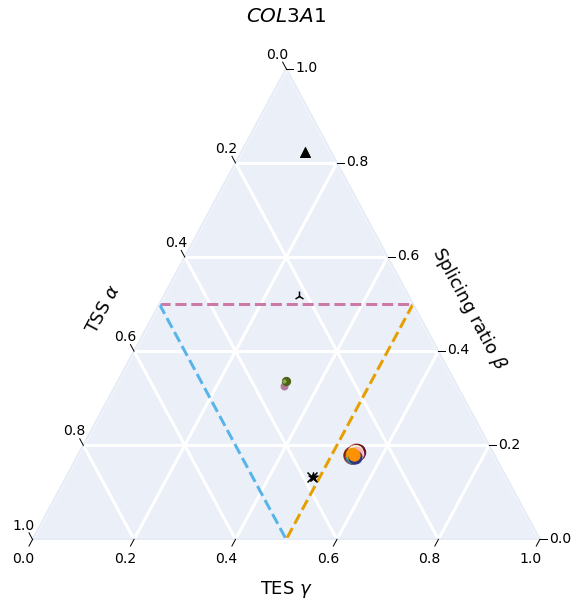

In [100]:
# COL3A1
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='COL3A1',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_90')

In [53]:
# reference + expressed triplets
e_trip = pd.read_csv('expressed_triplets.tsv', sep='\t')
s_trip = pd.read_csv('source_triplets.tsv', sep='\t')

# for now, hack together dfs to work with existing code
e_trip.rename({'sample': 'source'}, axis=1, inplace=True)
trips = pd.concat([s_trip, e_trip])
trips.loc[trips.source == 'lapa', 'source'] = 'obs'
trips.loc[trips.source=='all', 'source'] = 'cerberus'

In [53]:
# trips.loc[trips.gname=='TCF3']

In [37]:
c_dict, order = get_biosample_colors()
c_dict['v29'] = 'k'
c_dict['obs'] = 'k'
c_dict['v40'] = 'k'
c_dict['cerberus'] = 'k'


mmap = {'v40': '*', 'v29': 'x', 'obs': '^', 'cerberus': '2'}
# counts = pd.read_csv('triplets.tsv', sep='\t')

[100, 100, 100, 100, array([177.28005807])]


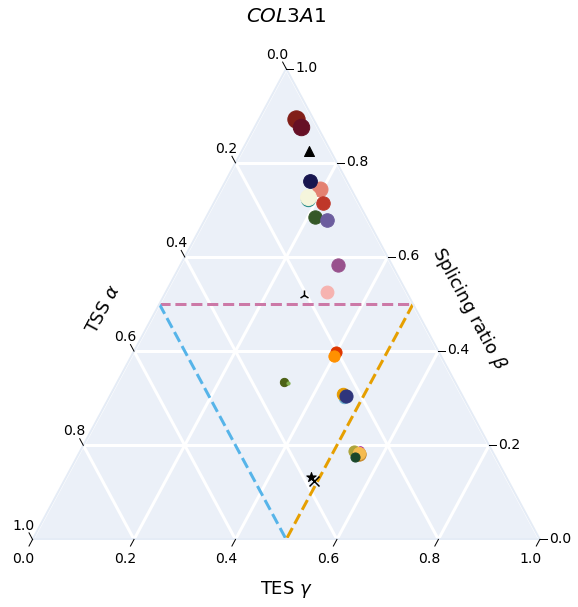

In [103]:
# COL3A1
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='COL3A1',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

[100, 100, 100, 100, array([140.79631889])]


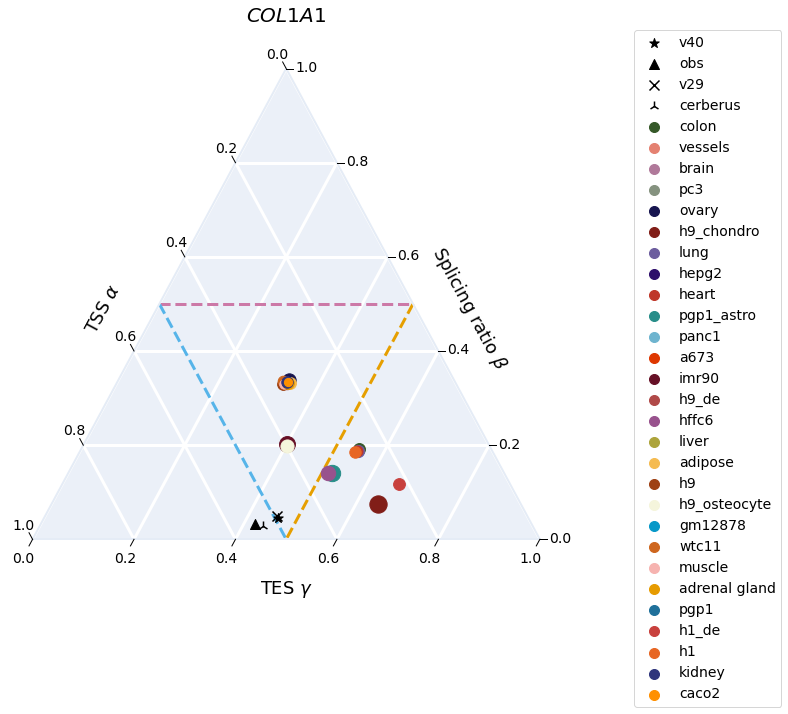

In [32]:
# COL1A1
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=True,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human')

[100, 100, 100, 100, array([84.58361718])]


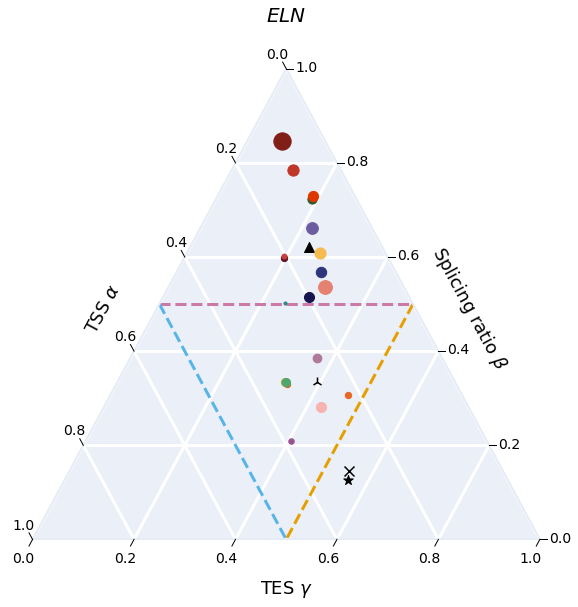

In [37]:
# ELN
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='ELN',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human')

[100, 100, 100, 100, array([239.20913705])]


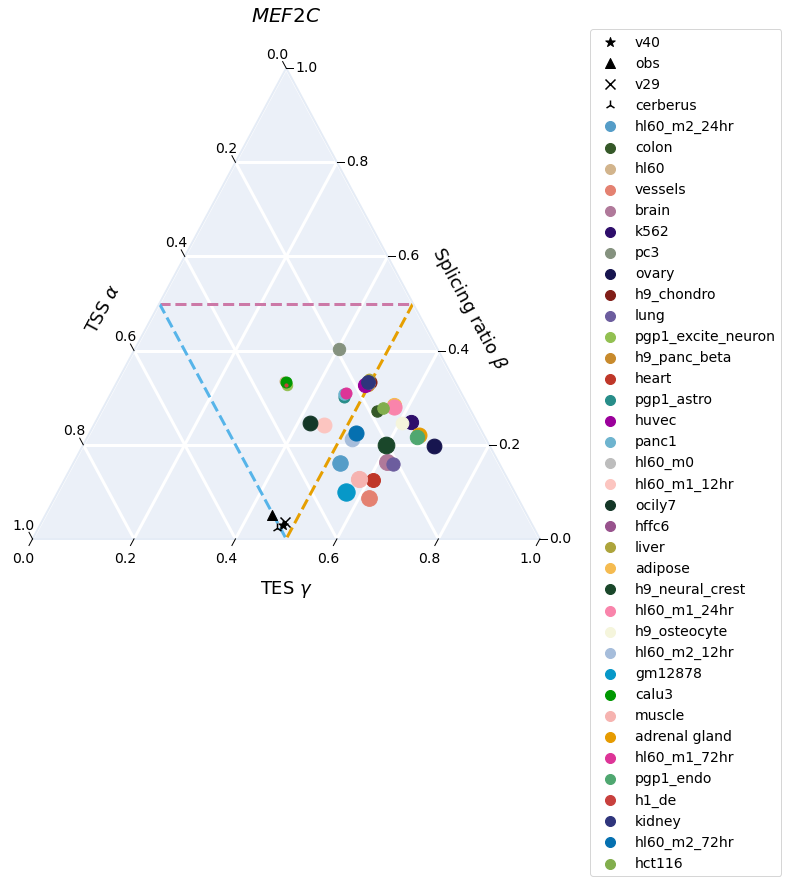

In [39]:
# MEF2C
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=True,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human')

[array([84.58361], dtype=float32), array([188.93686], dtype=float32), array([76.687355], dtype=float32), array([100.872086], dtype=float32), array([300.], dtype=float32)]
> <ipython-input-40-9df8a5236e8f>(289)scatter_dorito()
    287     if hue_type == 'cat':
    288         pdb.set_trace()
--> 289         for point, color, size, label, marker in zip(points, colors, sizes, labels, markers):
    290             tax.scatter([point], vmin=vmin, vmax=vmax,
    291                     s=size, c=color, cmap=cmap,



ipdb>  c


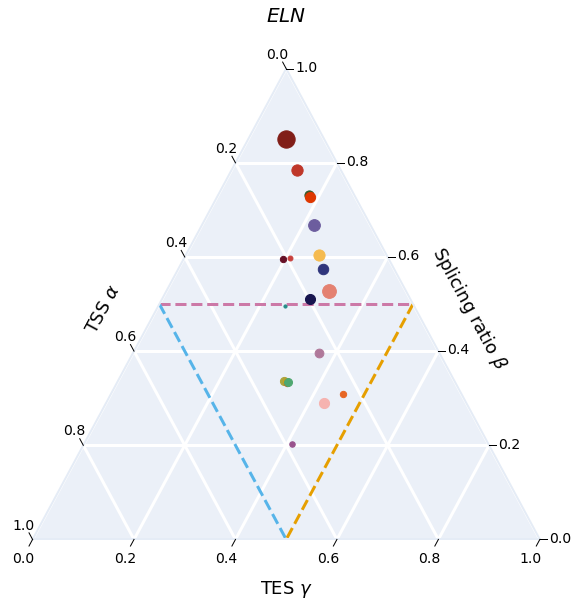

In [42]:
# ELN
c_dict, order = get_biosample_colors()
_ = plot_dorito(e_trip,
            top='splicing_ratio', 
            gene='ELN',
            hue='sample',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            legend=False,
            jitter=True)

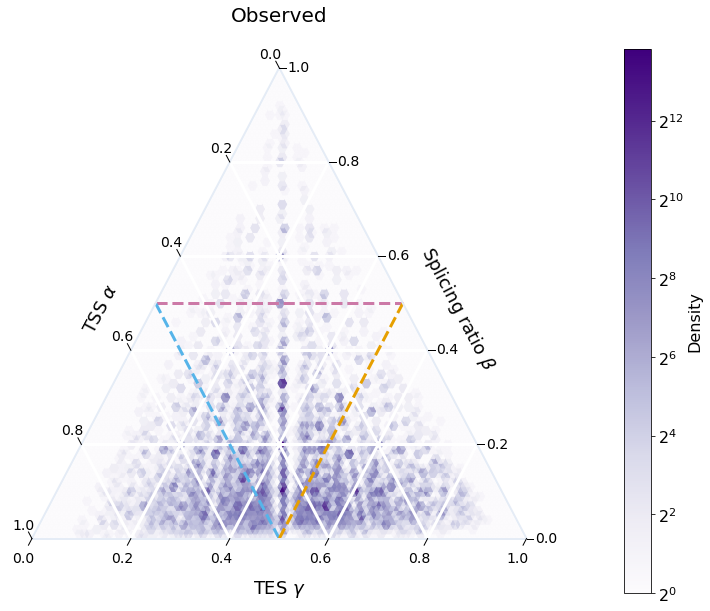

In [38]:
temp = plot_dorito(trips,
            top='splicing_ratio',
            subset={'source': 'obs'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed',
            opref='figures/human_obs')


In [40]:
beep = temp.copy(deep=True)
temp = assign_gisx_sector(temp)
temp[['gid', 'sector']].groupby('sector').count()

,gid
sector,
mixed,8383
simple,16085
splicing,618
tes,6398
tss,4872


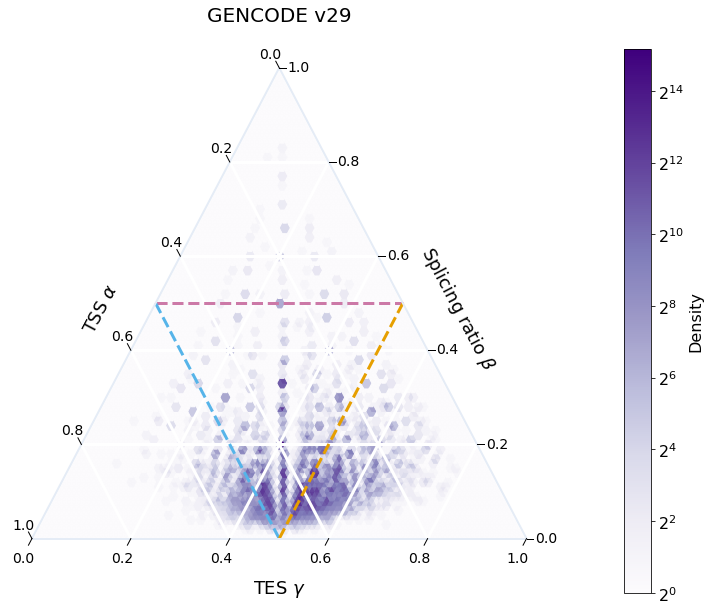

In [41]:
temp = plot_dorito(trips,
            top='splicing_ratio',
            subset={'source': 'v29'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            title='GENCODE v29',
            opref='figures/human_v29')

In [42]:
temp = assign_gisx_sector(temp)
temp[['gid', 'sector']].groupby('sector').count()

,gid
sector,
mixed,15464
simple,36287
splicing,300
tes,5085
tss,1644


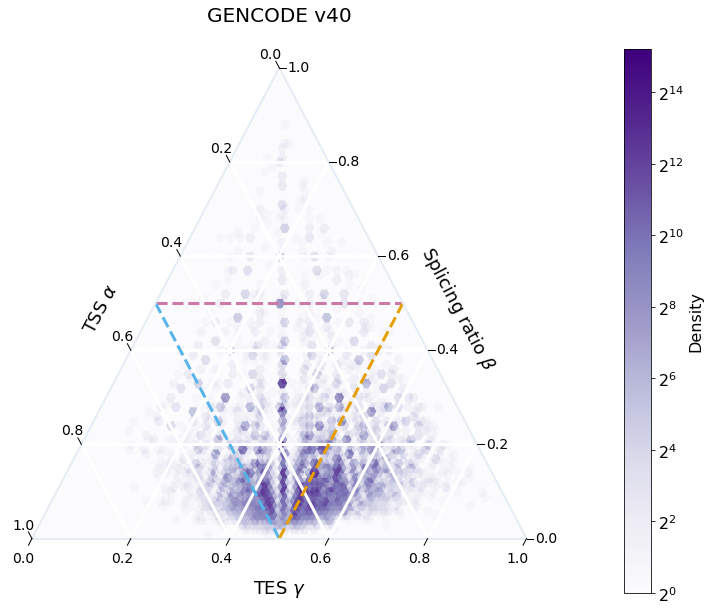

In [43]:
temp = plot_dorito(trips,
            top='splicing_ratio',
            subset={'source': 'v40'},
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            title='GENCODE v40',
            opref='figures/human_v40')

In [44]:
beep = pd.concat([beep, temp])
temp = assign_gisx_sector(temp)
temp[['gid', 'sector']].groupby('sector').count()
# temp.source.unique()

,gid
sector,
mixed,16138
simple,37393
splicing,534
tes,5688
tss,1791


In [ ]:
def get_sector_colors(cats=None):
    tss = '#56B4E9'
    tes = '#E69F00'
    splicing = '#CC79A7'
    simple = '#e5ecf6'
    c_dict = {'tss': tss,
              'splicing': splicing,
              'tes': tes,
              'simple': simple, 
              'mixed': '#b7b7b7'}
    order = ['tss', 'splicing', 'tes', 'mixed', 'simple']
    
    c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

def plot_sector_gene_counts(counts):
    temp = pd.DataFrame()
    for source in counts.source.unique():
        df = assign_gisx_sector(counts)
        df = df.loc[df.source == source]
        df = df[['gid', 'source', 'sector']].groupby(['source', 'sector']).count().reset_index()
        df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
        df['total_genes'] = df.n_genes.sum()
        temp = pd.concat([temp, df])
    temp['perc'] = (temp.n_genes/temp.total_genes)*100
    temp = temp.loc[temp.sector != 'simple'] 
    
    y = '% of total genes'
    temp.rename({'perc': y}, axis=1, inplace=True)
    c_dict, order = get_sector_colors(['tss', 'splicing', 'tes', 'mixed'])
    # plot both together
    sns.set_context('paper', font_scale=1.8)
    ax = sns.catplot(data=temp, x='source',
                y=y, hue='sector', kind='bar',
                palette=c_dict, saturation=1,
                hue_order=order)

    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
    #         x = p.get_x() + p.get_width() / 2 - 0.45
            x = p.get_x() + p.get_width() / 2 - (0.015)*n_cats
            y = p.get_y() + p.get_height() + ylim*0.00625
            ax.annotate(percentage, (x, y), size = 12)

    a = ax.axes[0,0]
    add_perc_2(a)
    
    return temp   

,source,sector,n_genes,total_genes,% of total genes
0,obs,mixed,8383,36356,23.058092
2,obs,splicing,618,36356,1.699857
3,obs,tes,6398,36356,17.598196
4,obs,tss,4872,36356,13.400814
0,v40,mixed,16138,61544,26.221890
2,v40,splicing,534,61544,0.867672
3,v40,tes,5688,61544,9.242168
4,v40,tss,1791,61544,2.910113


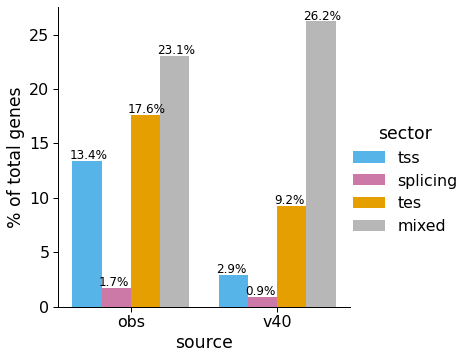

In [52]:
plot_sector_gene_counts(beep)

In [54]:
# reference + mouse match expressed triplets
e_trip = pd.read_csv('expressed_triplets.tsv', sep='\t')
s_trip = pd.read_csv('source_triplets.tsv', sep='\t')

# for now, hack together dfs to work with existing code
e_trip.rename({'sample': 'source'}, axis=1, inplace=True)
trips = pd.concat([s_trip, e_trip])
trips.loc[trips.source == 'lapa', 'source'] = 'obs'
trips.loc[trips.source=='all', 'source'] = 'cerberus'

mm_tissues = ['adrenal gland', 'heart', 'muscle', 'brain', 'pgp1_excite_neuron', 'pgp1_astro']
mm_annot = ['cerberus', 'v40', 'v29', 'all']
mm_sources = mm_tissues+mm_annot
trips = trips.loc[trips.source.isin(mm_sources)]

In [55]:
trips.source.unique()

array(['v40', 'v29', 'cerberus', 'brain', 'pgp1_excite_neuron', 'heart',
       'pgp1_astro', 'muscle', 'adrenal gland'], dtype=object)

In [56]:
c_dict, order = get_biosample_colors()
c_dict['v29'] = 'k'
c_dict['obs'] = 'k'
c_dict['v40'] = 'k'
c_dict['cerberus'] = 'k'


mmap = {'v40': '*', 'v29': 'x', 'obs': '^', 'cerberus': '2'}

[100, 100, 100, array([10.]), array([300.])]


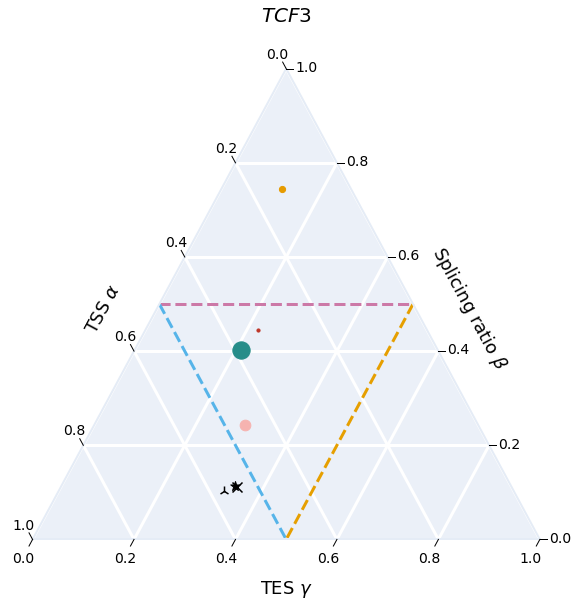

In [59]:
# TCF3
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

[100, 100, 100, array([77.14291214]), array([131.02573768])]


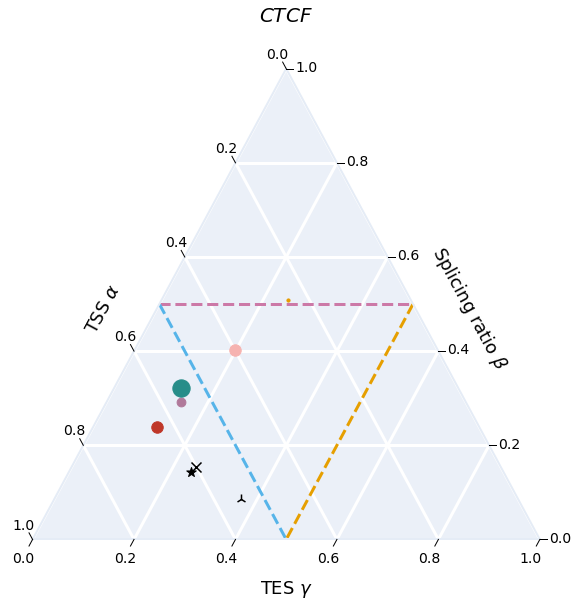

In [60]:
# TCF3
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='CTCF',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

[100, 100, 100, array([10.]), array([109.86794417])]


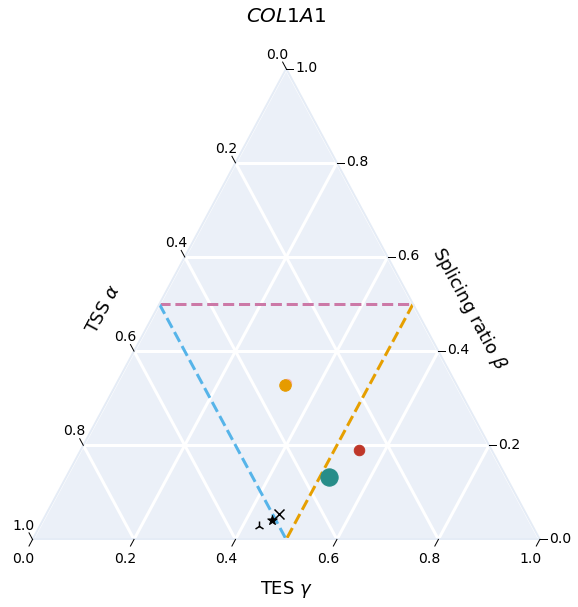

In [35]:
# COL1A1
df = plot_dorito(trips,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            size='gene_tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap=mmap,
            legend=False,
            jitter=True,
            # subset={'source':list(set(trips.source.unique().tolist())-set(['all']))}, 
            opref='figures/human_')

In [30]:
trips.loc[trips.gname =='COL1A1']

,Unnamed: 0,gid,n_tss,n_tes,n_ic,source,splicing_ratio,gname,n_iso,gene_tpm
39947,39947,ENSG00000108821,12.0,11.0,13.0,v40,1.130435,COL1A1,13.0,NaN
101491,101491,ENSG00000108821,12.0,11.0,13.0,v29,1.130435,COL1A1,13.0,NaN
160695,160695,ENSG00000108821,20.0,16.0,15.0,cerberus,0.833333,COL1A1,0.0,NaN
55689,55689,ENSG00000108821,1.0,1.0,1.0,brain,1.000000,COL1A1,1.0,2.852873
180963,180963,ENSG00000108821,1.0,2.0,1.0,heart,0.666667,COL1A1,2.0,57.795326
471228,471228,ENSG00000108821,1.0,1.0,1.0,muscle,1.000000,COL1A1,1.0,18.003805
483372,483372,ENSG00000108821,1.0,1.0,1.0,adrenal gland,1.000000,COL1A1,1.0,110.667440


In [389]:
trip_df = get_expressed_triplets(c_annot, sg, obs_col='sample', min_tpm=1)

In [390]:
trip_df.head()

,gid,sample,tid,n_tss,n_ic,n_tes,gene_tpm,splicing_ratio,gname
0,ENSG00000000003,hepg2,6,1,3,4,191.014984,1.2,TSPAN6
1,ENSG00000000419,hepg2,6,1,6,2,62.502338,4.0,DPM1
2,ENSG00000000457,hepg2,1,1,1,1,3.207075,1.0,SCYL3
3,ENSG00000000460,hepg2,3,2,3,2,8.606131,1.5,C1orf112
4,ENSG00000001036,hepg2,7,1,5,4,282.548126,2.0,FUCA2


In [206]:
# calculate pi values to get weighted triplet
t_df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col=gb) # this boi is sparse

In [210]:
# add additional stuff to end adatas
sg.tss_adata.var['gene_id'] = sg.tss_adata.var['gid']
sg.tss_adata.var = add_stable_gid(sg.tss_adata.var)
sg.tss_adata.var = sg.tss_adata.var.merge(sg.loc_df[['chrom', 'coord']],
                                          how='left', left_on='vertex_id', 
                                          right_index=True)

In [326]:
def check_gene_sample(sample, gene):
    n_tss = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'tss_id'].unique())
    n_ic = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'ic_id'].unique())
    n_tes = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene), 'tes_id'].unique())
    n_t = len(t_df.loc[(t_df[sample])&(t_df.gene_id == gene)].index.unique())
    
    print('Triplet for {}, {}: [{},{},{}]'.format(sample, gene, n_tss, n_ic, n_tes))
    print('n transcripts: {}'.format(n_t))


In [328]:
# check_gene_sample('hepg2', 'ENSG00000000003')

In [110]:
tss_map = c_annot.tss_map
tss_map = tss_map.loc[~tss_map.Name.isnull()]
tss_map['gene_id'] = tss_map.Name.str.split('_', expand=True)[0]
tss_map.loc[(tss_map.gene_id.isin(t))&(tss_map.source == 'v29')]

,Chromosome,Start,End,Strand,source,Name,gene_id
13224,chr1,11908096,11908197,+,v29,ENSG00000285646_2,ENSG00000285646
13225,chr1,11908101,11908202,+,v29,ENSG00000199347_1,ENSG00000199347
13249,chr1,12166892,12166993,+,v29,ENSG00000283789_1,ENSG00000283789
13510,chr1,16643058,16643159,-,v29,ENSG00000283773_1,ENSG00000283773
14056,chr1,25337414,25337515,-,v29,ENSG00000259984_1,ENSG00000259984
...,...,...,...,...,...,...,...
2484818,chrX,102599461,102599590,+,v29,ENSG00000271147_3,ENSG00000271147
2484821,chrX,147911771,147911872,+,v29,ENSG00000274086_2,ENSG00000274086
2484822,chrX,73944281,73944382,+,v29,ENSG00000274430_2,ENSG00000274430
2484823,chrX,155382064,155382165,+,v29,ENSG00000274791_1,ENSG00000274791


In [104]:
tes.loc[tes.gene_id == 'ENSG00000277577']

,gene_id,n_tes
54299,ENSG00000277577,1


In [88]:
tss.head()

,gene_id,n_tss
0,ENSG00000000003,3
1,ENSG00000000005,2
2,ENSG00000000419,2
3,ENSG00000000457,3
4,ENSG00000000460,5


In [83]:
tss = tss[['Name', 'gene_id']].groupby('gene_id').count().reset_index()
tss.rename({'Name

In [84]:
tss.head()

,Name
gene_id,
ENSG00000000003,3
ENSG00000000005,2
ENSG00000000419,2
ENSG00000000457,3
ENSG00000000460,5


## Merge cerberus end ids with preexisting ones

In [297]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [311]:
def annotate_cerberus_ends(sg, c_annot, mode):
    """
    Annotate each end in Swan with the cerberus end that it comes from
    """
    if mode == 'tss':
        path_ind = 0
        adata = sg.tss_adata
    elif mode == 'tes':
        path_ind = -1
        adata = sg.tes_adata
    id_col = '{}_id'.format(mode)
    
    ends = [path[path_ind] for path in sg.t_df.loc_path.values.tolist()]
    temp = sg.t_df[[id_col]]
    temp['vertex_id'] = ends
    temp.reset_index(drop=True, inplace=True)
    temp.drop_duplicates(inplace=True)
    
    temp.rename({id_col: 'cerberus_id'}, axis=1, inplace=True)
    # adata.var = adata.var.merge(temp, how='left', on='vertex_id')
    
    return temp

In [312]:
temp = annotate_cerberus_ends(sg, c_annot, mode='tss')

In [318]:
temp.loc[temp.vertex_id.duplicated(keep=False)].sort_values(by='vertex_id')

,cerberus_id,vertex_id
292415,ENSG00000251503_13,6412
207278,ENSG00000175279_9,6412
86522,ENSG00000120948_12,6651
316756,ENSG00000277726_4,6651
203405,ENSG00000173436_6,11200
...,...,...
258230,ENSG00000214827_11,882879
258233,ENSG00000214827_8,882880
220179,ENSG00000182712_6,882880
320001,ENSG00000282909_3,885814


In [320]:
temp2.loc[temp2.vertex_id == 6651]

,gid,gname,vertex_id,tss_name
tss_id,,,,
ENSG00000120948.17_5,ENSG00000120948.17,TARDBP,6651,TARDBP_5


In [316]:
temp2 = sg.tss_adata.var.copy(deep=True)
temp2.head()
temp2 = temp2.merge(temp, how='left', on='cerberus_id')

KeyError: 'cerberus_id'

In [272]:
# merge cerberus tes
ends = [path[-1] for path in sg.t_df.loc_path.values.tolist()]
temp = sg.t_df[['tes_id']]
temp['vertex_id'] = ends
temp_tid = temp.copy(deep=True)
temp.reset_index(drop=True, inplace=True)
temp.drop_duplicates(inplace=True)

In [273]:
temp3 = temp.loc[temp.tes_id.duplicated(keep=False)].sort_values(by='tes_id')
print(len(temp3.tes_id.unique()))
# print(temp3.sort_values(by='tss_id'))
dupes = temp3.vertex_id.tolist()

temp2 = sg.loc_df.loc[dupes].reset_index(drop=True)
temp2 = temp2.merge(temp.reset_index(), how='left', on='vertex_id')
# print(temp.loc[temp.vertex_id.isin(dupes)])

2


In [284]:
c_annot.t_map.loc[c_annot.t_map.tss_first_sd_issue]

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id_x,transcript_name,transcript_id_y,tss_first_sd_issue,tes_last_sa_issue
4920,ENCODEHT002874391,6,ENSG00000237457_6,ENSG00000237457_2,2,ENSG00000237457_2,2,ENSG00000237457,LINC01351,ENCODEHT002874391,"[2,6,2]","ENSG00000237457[2,6,2]","LINC01351[2,6,2]",ENCODEHT002874391,True,False
19558,ENCODEHT003200255,5,ENSG00000118729_5,ENSG00000118729_1,1,ENSG00000118729_1,1,ENSG00000118729,CASQ2,ENCODEHT003200255,"[1,5,1]","ENSG00000118729[1,5,1]","CASQ2[1,5,1]",ENCODEHT003200255,True,False
19559,ENCODEHT003200255#1,5,ENSG00000118729_5,ENSG00000118729_1,1,ENSG00000118729_1,1,ENSG00000118729,CASQ2,ENCODEHT003200255,"[1,5,1]","ENSG00000118729[1,5,1]","CASQ2[1,5,1]",ENCODEHT003200255#1,True,False
154359,ENCODEHT000849603,10,ENSG00000136536_10,ENSG00000136536_1,1,ENSG00000136536_3,3,ENSG00000136536,MARCH7,ENCODEHT000849603,"[1,10,3]","ENSG00000136536[1,10,3]","MARCH7[1,10,3]",ENCODEHT000849603,True,False
154360,ENCODEHT000849603#0,10,ENSG00000136536_10,ENSG00000136536_1,1,ENSG00000136536_3,3,ENSG00000136536,MARCH7,ENCODEHT000849603,"[1,10,3]","ENSG00000136536[1,10,3]","MARCH7[1,10,3]",ENCODEHT000849603#0,True,False
173625,ENCODEHT001066979,6,ENSG00000125871_6,ENSG00000125871_1,1,ENSG00000125871_1,1,ENSG00000125871,MGME1,ENCODEHT001066979,"[1,6,1]","ENSG00000125871[1,6,1]","MGME1[1,6,1]",ENCODEHT001066979,True,False
193601,ENCODEHT005402898,8,ENSG00000163536_8,ENSG00000163536_2,2,ENSG00000163536_1,1,ENSG00000163536,SERPINI1,ENCODEHT005402898,"[2,8,1]","ENSG00000163536[2,8,1]","SERPINI1[2,8,1]",ENCODEHT005402898,True,False
193602,ENCODEHT005402898#0,8,ENSG00000163536_8,ENSG00000163536_2,2,ENSG00000163536_1,1,ENSG00000163536,SERPINI1,ENCODEHT005402898,"[2,8,1]","ENSG00000163536[2,8,1]","SERPINI1[2,8,1]",ENCODEHT005402898#0,True,False
200963,ENCODEHT000709998,5,ENSG00000186265_5,ENSG00000186265_1,1,ENSG00000186265_1,1,ENSG00000186265,BTLA,ENCODEHT000709998,"[1,5,1]","ENSG00000186265[1,5,1]","BTLA[1,5,1]",ENCODEHT000709998,True,False
200964,ENCODEHT000709998#0,5,ENSG00000186265_5,ENSG00000186265_1,1,ENSG00000186265_1,1,ENSG00000186265,BTLA,ENCODEHT000709998,"[1,5,1]","ENSG00000186265[1,5,1]","BTLA[1,5,1]",ENCODEHT000709998#0,True,False


In [285]:
c_annot.t_map.loc[c_annot.t_map.tes_last_sa_issue]

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id_x,transcript_name,transcript_id_y,tss_first_sd_issue,tes_last_sa_issue
23316,ENST00000371225.3#0,3,ENSG00000184292_3,ENSG00000184292_1,1,ENSG00000184292_1,1,ENSG00000184292,TACSTD2,TACSTD2-201,"[1,3,1]","ENSG00000184292[1,3,1]","TACSTD2[1,3,1]",ENST00000371225.3#0,False,True
25031,ENST00000436555.1,2,ENSG00000181201_2,ENSG00000181201_1,1,ENSG00000181201_1,1,ENSG00000181201,HIST3H2BA,HIST3H2BA-201,"[1,2,1]","ENSG00000181201[1,2,1]","HIST3H2BA[1,2,1]",ENST00000436555.1,False,True
25957,ENST00000468715.1#0,2,ENSG00000137970_2,ENSG00000137970_1,1,ENSG00000137970_1,1,ENSG00000137970,RPL7P9,RPL7P9-201,"[1,2,1]","ENSG00000137970[1,2,1]","RPL7P9[1,2,1]",ENST00000468715.1#0,False,True
25958,ENST00000468715.1#1,3,ENSG00000137970_3,ENSG00000137970_1,1,ENSG00000137970_1,1,ENSG00000137970,RPL7P9,RPL7P9-201,"[1,3,1]","ENSG00000137970[1,3,1]","RPL7P9[1,3,1]",ENST00000468715.1#1,False,True
31838,ENST00000366529.4#0,2,ENSG00000213025_2,ENSG00000213025_2,2,ENSG00000213025_1,1,ENSG00000213025,COX20P1,COX20P1-201,"[2,2,1]","ENSG00000213025[2,2,1]","COX20P1[2,2,1]",ENST00000366529.4#0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272902,ENST00000607376.1#0,2,ENSG00000272172_2,ENSG00000272172_2,2,ENSG00000272172_1,1,ENSG00000272172,AC138696.2,AC138696.2-201,"[2,2,1]","ENSG00000272172[2,2,1]","AC138696.2[2,2,1]",ENST00000607376.1#0,False,True
277024,ENST00000435128.2#0,2,ENSG00000231991_2,ENSG00000231991_1,1,ENSG00000231991_1,1,ENSG00000231991,ANXA2P2,ANXA2P2-201,"[1,2,1]","ENSG00000231991[1,2,1]","ANXA2P2[1,2,1]",ENST00000435128.2#0,False,True
281356,ENST00000356628.3#0,3,ENSG00000198435_3,ENSG00000198435_1,1,ENSG00000198435_2,2,ENSG00000198435,NRARP,NRARP-201,"[1,3,2]","ENSG00000198435[1,3,2]","NRARP[1,3,2]",ENST00000356628.3#0,False,True
286676,ENST00000374888.2,2,ENSG00000198455_2,ENSG00000198455_2,2,ENSG00000198455_1,1,ENSG00000198455,ZXDB,ZXDB-201,"[2,2,1]","ENSG00000198455[2,2,1]","ZXDB[2,2,1]",ENST00000374888.2,False,True


In [296]:
c_annot.ic.loc[c_annot.ic.Name == 'ENSG00000184292_3']
c_annot.ic.loc[c_annot.ic.Name == 'ENSG00000137970_2']

# print(c_annot.tss.loc[c_annot.tss.Name == 'ENSG00000184292_1'])
# print(c_annot.tes.loc[c_annot.tes.Name == 'ENSG00000184292_1'])

,Chromosome,Strand,Coordinates,Name,source,gene_id,ic
255155,chr1,-,96678782,ENSG00000137970_2,lapa,ENSG00000137970,2


In [269]:
temp2[['chrom', 'coord', 'vertex_id', 'tes_id']]

,chrom,coord,vertex_id,tes_id
0,chr20,45892297,536059,ENSG00000064601_3
1,chr20,45892398,536061,ENSG00000064601_3
2,chr18,24195985,396806,ENSG00000141447_5
3,chr18,24195965,396805,ENSG00000141447_5


In [288]:
c_annot.tes.loc[c_annot.tes.Name == 'ENSG00000184292_1']

,Chromosome,Start,End,Strand,Name,source,gene_id,tes
16355,chr1,58575382,58575483,-,ENSG00000184292_1,"v40,v29,lapa,lapa,pas,polya_atlas",ENSG00000184292,1


In [277]:
sg.t_df.loc[sg.t_df.tes_id == 'chr20:45,889,600-45,894,122']

,tname,gid,gname,path,tid,tss_id,ic_id,tes_id,loc_path,annotation,novelty
tid,,,,,,,,,,,
"ENCODEHG000058784[1,1,2]","ENCODEHG000058784[1,1,2]",ENCODEHG000058784,ENCODEHG000058784,"[869616, 869598, 869617, 869602, 869618]","ENCODEHG000058784[1,1,2]",ENCODEHG000058784_1,ENCODEHG000058784_1,ENCODEHG000058784_2,"[43, 41, 40, 37, 36, 34]",False,Undefined
"ENCODEHG000058784[2,2,1]","ENCODEHG000058784[2,2,1]",ENCODEHG000058784,ENCODEHG000058784,"[869595, 869596, 869597, 869598, 869599, 86960...","ENCODEHG000058784[2,2,1]",ENCODEHG000058784_2,ENCODEHG000058784_2,ENCODEHG000058784_1,"[45, 44, 42, 41, 40, 39, 38, 37, 36, 35, 33, 3...",False,Undefined
"ENCODEHG000058837[1,1,1]","ENCODEHG000058837[1,1,1]",ENCODEHG000058837,ENCODEHG000058837,"[869593, 869579, 869580, 869581, 869594, 86958...","ENCODEHG000058837[1,1,1]",ENCODEHG000058837_1,ENCODEHG000058837_1,ENCODEHG000058837_1,"[11, 9, 8, 6, 5, 2, 1, 0]",False,Undefined
"ENCODEHG000058837[2,2,1]","ENCODEHG000058837[2,2,1]",ENCODEHG000058837,ENCODEHG000058837,"[869587, 869588, 869578, 869579, 869580, 86958...","ENCODEHG000058837[2,2,1]",ENCODEHG000058837_2,ENCODEHG000058837_2,ENCODEHG000058837_1,"[17, 12, 10, 9, 8, 6, 5, 4, 3, 2, 1, 0]",False,Undefined
"ENCODEHG000058837[2,3,1]","ENCODEHG000058837[2,3,1]",ENCODEHG000058837,ENCODEHG000058837,"[869589, 869590, 869591, 869592, 869586]","ENCODEHG000058837[2,3,1]",ENCODEHG000058837_2,ENCODEHG000058837_3,ENCODEHG000058837_1,"[17, 13, 7, 6, 1, 0]",False,Undefined


In [276]:
c_annot.tes.loc[c_annot.tes.Name=='ENSG00000064601_3']
c_annot.t_map.loc[c_annot.t_map.tes_id=='ENSG00000064601_3']

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name


In [259]:
# merge cerberus tss
tss = [path[0] for path in sg.t_df.loc_path.values.tolist()]
temp = sg.t_df[['tss_id']]
temp['vertex_id'] = tss
temp_tid = temp.copy(deep=True)
temp.reset_index(drop=True, inplace=True)
temp.drop_duplicates(inplace=True)

In [256]:
temp3 = temp.loc[temp.tss_id.duplicated(keep=False)].sort_values(by='tss_id')
# print(len(temp3.tss_id.unique()))
# print(temp3.sort_values(by='tss_id'))
dupes = temp3.vertex_id.tolist()

temp2 = sg.loc_df.loc[dupes].reset_index(drop=True)
temp2 = temp2.merge(temp.reset_index(), how='left', on='vertex_id')
# print(temp.loc[temp.vertex_id.isin(dupes)])

In [258]:
temp2[['chrom', 'coord', 'vertex_id', 'tss_id']]

,chrom,coord,vertex_id,tss_id
0,chr1,115768764,44893,ENSG00000118729_1
1,chr1,115768836,44894,ENSG00000118729_1
2,chr9,34590190,826562,ENSG00000122756_2
3,chr9,34590230,826563,ENSG00000122756_2
4,chr20,17968968,526857,ENSG00000125871_1
5,chr20,17968940,526856,ENSG00000125871_1
6,chr2,159712407,496694,ENSG00000136536_1
7,chr2,159712382,496693,ENSG00000136536_1
8,chr3,167735193,615571,ENSG00000163536_2
9,chr3,167735170,615570,ENSG00000163536_2


In [264]:
temp_tid.loc[temp_tid.tss_id== 'ENSG00000125871_3']

,tss_id,vertex_id
tid,,
"ENSG00000125871[3,1,1]",ENSG00000125871_3,526851
"ENSG00000125871[3,6,1]",ENSG00000125871_3,526851


In [265]:
c_annot.tss.loc[c_annot.tss.gene_id == 'ENSG00000125871']

,Chromosome,Start,End,Strand,Name,source,gene_id,tss
158877,chr20,17968967,17969165,+,ENSG00000125871_1,"v40,v29,lapa,lapa,encode_cage,fantom_cage,enco...",ENSG00000125871,1
158878,chr20,17969980,17970107,+,ENSG00000125871_2,"v40,v29,lapa,lapa,encode_cage,fantom_cage,enco...",ENSG00000125871,2
158879,chr20,17968540,17968641,+,ENSG00000125871_3,"lapa,fantom_cage,pls",ENSG00000125871,3


In [263]:
c_annot.t_map.loc[c_annot.t_map.transcript_id == 'ENSG00000125871[1,6,1]']

,original_transcript_id,ic,ic_id,tss_id,tss,tes_id,tes,gene_id,gene_name,original_transcript_name,transcript_triplet,transcript_id,transcript_name
173625,ENCODEHT001066979,6,ENSG00000125871_6,ENSG00000125871_1,1,ENSG00000125871_1,1,ENSG00000125871,MGME1,ENCODEHT001066979,"[1,6,1]","ENSG00000125871[1,6,1]","MGME1[1,6,1]"


In [ ]:
# coords where this is happening to tsss
# chr1:115,768,231-115,769,532
# chr9:34,588,278-34,590,705
# chr20:17,967,704-17,969,965 -not sure what's going on here, shoulda worked
# chr2:159,709,254-159,717,753
# chr3:167,734,324-167,736,063
# chr1:190,478,112-190,478,657
#
# tes
# chr20:45,889,600-45,894,122 - in v29 gtf
# chr18:24,150,854-24,241,116

In [243]:
c_annot.tss.loc[c_annot.tss.Name == 'ENSG00000118729_1']
c_annot.tss.loc[c_annot.tss.gene_id == 'ENSG00000118729']

,Chromosome,Start,End,Strand,Name,source,gene_id,tss
9556,chr1,115768663,115768764,-,ENSG00000118729_1,"v40,v29,lapa,lapa,fantom_cage,encode_rampage,pls",ENSG00000118729,1
9557,chr1,115732876,115732977,-,ENSG00000118729_2,"v40,v29",ENSG00000118729,2
9558,chr1,115701369,115701370,-,ENSG00000118729_3,lapa,ENSG00000118729,3


In [240]:
115768836 < 115768764


False

7
                   tss_id  vertex_id
82627   ENSG00000118729_1      44893
82632   ENSG00000118729_1      44894
89278   ENSG00000122756_2     826562
89280   ENSG00000122756_2     826563
94950   ENSG00000125871_1     526857
94955   ENSG00000125871_1     526856
118123  ENSG00000136536_1     496694
118126  ENSG00000136536_1     496693
172151  ENSG00000163536_2     615571
172156  ENSG00000163536_2     615570
228422  ENSG00000186265_1     600796
228429  ENSG00000186265_1     600797
280336  ENSG00000237457_2      68139
280337  ENSG00000237457_2      68138


,tss_id,vertex_id
0,ENCODEHG000058784_1,43
1,ENCODEHG000058784_2,45
2,ENCODEHG000058837_1,11
3,ENCODEHG000058837_2,17
6,ENCODEHG000058844_1,46


In [225]:
c_annot.tss.loc[c_annot.tss.Name == 'ENSG00000118729_1']

,Chromosome,Start,End,Strand,Name,source,gene_id,tss
9556,chr1,115768663,115768764,-,ENSG00000118729_1,"v40,v29,lapa,lapa,fantom_cage,encode_rampage,pls",ENSG00000118729,1


In [226]:
c_annot.tss_map.loc[c_annot.tss_map.Name == 'ENSG00000118729_1']

,Chromosome,Start,End,Strand,source,Name
7225,chr1,115768663,115768764,-,v40,ENSG00000118729_1
18043,chr1,115768730,115768831,-,v29,ENSG00000118729_1
25210,chr1,115768707,115768833,-,lapa,ENSG00000118729_1
32807,chr1,115768682,115768948,-,lapa,ENSG00000118729_1
50423,chr1,115768675,115768686,-,fantom_cage,ENSG00000118729_1
50424,chr1,115768702,115768725,-,fantom_cage,ENSG00000118729_1
50425,chr1,115768727,115768739,-,fantom_cage,ENSG00000118729_1
50426,chr1,115768746,115768761,-,fantom_cage,ENSG00000118729_1
50427,chr1,115768783,115768792,-,fantom_cage,ENSG00000118729_1
66906,chr1,115768659,115768792,-,encode_rampage,ENSG00000118729_1


In [251]:
print(115768898+50)
print(115768898-50)

115768948
115768848


In [146]:
sg.tss_adata.var = sg.tss_adata.var.merge(temp, how='left', on='vertex_id')

ValueError: Length of passed value for var_names is 60176, but this AnnData has shape: (138, 59949)

In [160]:
temp.loc[temp.tss_id.duplicated(keep=False)]

,tss_id,vertex_id
75026,ENSG00000115255_2,408911
75027,ENSG00000115255_2,408910
82470,ENSG00000118729_1,44886
82475,ENSG00000118729_1,44887
89087,ENSG00000122756_2,826409
89089,ENSG00000122756_2,826410
94746,ENSG00000125871_1,526755
94751,ENSG00000125871_1,526754
95830,ENSG00000126522_6,758742
95831,ENSG00000126522_6,758741


,chrom,coord,vertex_id,annotation,internal,TSS,TES
vertex_id,,,,,,,
408910,chr19,1495387,408910,True,True,True,False
408911,chr19,1495426,408911,True,True,True,False
